In [1]:
import pandas as pd
import csv
import numpy as np
from collections import defaultdict
import copy
import re
from datetime import datetime, timedelta


pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [2]:
skl_dol = pd.read_excel('/home/novozhilovsv/PROJECT/python_next_level/DATA/Реестр СКЛ_ДОЛ.xlsx')
benefits = pd.read_excel('/home/novozhilovsv/PROJECT/python_next_level/DATA/Поощрения.xlsx')
children = pd.read_excel('/home/novozhilovsv/PROJECT/python_next_level/DATA/Многодетные.xlsx')
guardians = pd.read_excel('/home/novozhilovsv/PROJECT/python_next_level/DATA/Опекуны.xlsx')
profi = pd.read_excel('/home/novozhilovsv/PROJECT/python_next_level/DATA/Лучший по профессии.xlsx')
exp_parents = pd.read_excel('/home/novozhilovsv/PROJECT/python_next_level/DATA/Стажи и одинокие родители.xlsx')


In [3]:
# Функция удаления пустых строк по нулевому значению в столбце
def dropna_column(df, column):
    df[column].replace('', np.nan, inplace=True)
    df.dropna(subset=[column], inplace=True)
    return df
    

In [4]:
# Тут отфильтрованы тока те нагржденцы, кто есть в списках путевок (таких оказалось 354)
def filter_column(benefits, skl_dol, ben_colum, skl_dol_colum, dtype='int64'):
    skl_dol = dropna_column(skl_dol, skl_dol_colum)
    benefits = dropna_column(benefits, ben_colum)
    new_benefits = benefits.loc[benefits[ben_colum].astype(dtype).isin(list(skl_dol[skl_dol_colum].astype(dtype)))]
    return new_benefits


In [5]:
'''
Функция подсчета количества детей, формирует таблицу вида:
children_dict = [
                    {
                        'Предприятие': 'Бамблби',
                        'Таб. номер': 123,
                        'ФИО': 'Василий Алибабаевич',
                        'Дата рождения': 12.16.1365,
                        'count_child': 2
                    }
]
'''
def count_cild(new_children):
    children_dict = []
    tab_num = []
    new_person2 = {}

    for i, row in new_children.iterrows():
        new_person = copy.deepcopy(new_person2)
        row = list(row)
        try:
            tab = int(row[2])
        except Exception:
            continue

        child_age = int(str(row[7]).split('.')[-1])

        if (2019 - child_age) >= 18:
            continue

        if tab in tab_num:
            for index, person in enumerate(children_dict):
                if person.get('Таб. номер') == tab:
                    children_dict[index]['count_child'] += 1
                    break
        else:
            tab_num.append(tab)
            new_person['Предприятие'] = row[1]
            new_person['Таб. номер'] = tab
            new_person['ФИО'] = row[3]
            new_person['Дата рождения'] =row[4] 
            new_person['count_child'] = 1
            children_dict.append(new_person)
    
    new_children_count = pd.DataFrame(children_dict)  
    return new_children_count
        


In [6]:
def guardians_clean(df, companies):
    
    'Guardian data frame preprocessing'
    
    df.dropna(axis=0, inplace=True)
    df['Дата рождения ребенка'] = pd.to_datetime(df['Дата рождения ребенка'])
    df['Age'] = pd.to_datetime('now') - df['Дата рождения ребенка']
    df['Age'] = df['Age'] /  np.timedelta64(1, 'Y')
    df['is_child'] = df['Age'].apply(lambda x:  0 if x >= 18 else 1 )
    df = df[df['is_child'] == 1]
    df = df[df['Предприятие'].isin(companies)]
    
    return df

In [7]:
def professionals(df):
    'Professionals data frame preprocessing'
    
    df.drop(['Период действия С ','Мотив для поощрения'], axis = 1, inplace=True)
    
    return df

In [8]:
def work_expirients(df, companies):
    'Preprocessing a data frame that consisted work expirience and childs marks'

    idx = df['Табельный  №'].isnull()
    df = df[idx==False]
    df = df[df['Предприятие'].isin(companies)]
    
    
    return df

In [9]:
companies  = skl_dol['Предприятие'].dropna().drop_duplicates(keep='first', inplace=False)


In [10]:
new_benefits = filter_column(benefits, skl_dol, 'Таб №', 'Таб. номер (заявителя)')
new_children = filter_column(children, skl_dol, 'Таб. номер', 'Таб. номер (заявителя)')

# ИТОГОВАЯ ТАБЛИЧКА С МНОГОДЕТАМИ
new_children_count = count_cild(new_children)

len(set(new_benefits['Таб №']))

313

In [11]:
# keys = [
# 'Вид путевки_Дол',
# 'Вид путевки_CКЛ'
# 'Предприятие', 
# 'Таб. номер (заявителя)', 
# 'ФИО сотрудника (заявителя)', 
# 'Должность', 'Подразделение', 
# 'Город вылета/возвращения', 
# 'Дисциплинарные взыскания', 
# 'гости', 
# 'Дата заезда', 
# 'Дата выезда', 
# '№ заявки', 
# 'количество_заявок'
# 'Дата подачи']


skl_dol = dropna_column(skl_dol, 'Таб. номер (заявителя)')

head = list(skl_dol[:0])
print(head)

def handle_ckl_dol(skl_dol):
    skl_dol_dict = []
    tab_num = []
    new_person2 = {}

    for i, row in skl_dol.iterrows():
        pattern_dol = r'ДОЛ'
        pattern_skl = r'СКЛ'

        new_person = copy.deepcopy(new_person2)
        row = list(row)
        tab = int(row[3])
        row[1] = str(row[1])
    #     print(row)

        if tab in tab_num:

            for index, person in enumerate(skl_dol_dict):
    #             print(row)
    #             print(person)
                if person.get('Таб. номер (заявителя)') == tab:

                    if re.search(pattern_dol, row[1]): 
                        skl_dol_dict[index]['Вид путевки_Дол'] += 1
                    elif re.search(pattern_skl, row[1]):
                        skl_dol_dict[index]['Вид путевки_CКЛ'] += 1
                    else:
                        print(row)

        else:

            if re.search(pattern_dol, row[1]):
                new_person['Вид путевки_Дол'] = 1
                new_person['Вид путевки_CКЛ'] = 0
            else:
                new_person['Вид путевки_CКЛ'] = 1
                new_person['Вид путевки_Дол'] = 0

            tab_num.append(tab)
            new_person['Предприятие'] = row[2]
            new_person['Таб. номер (заявителя)'] = tab
            new_person['ФИО сотрудника (заявителя)'] = row[4]
            new_person['Должность'] =row[5]
            new_person['Подразделение'] = row[6]
            new_person['Город вылета/возвращения'] = row[7]
            new_person['Дисциплинарные взыскания'] = row[8]

            if row[10] != np.nan:
                new_person['гости'] = 1
            else:
                new_person['гости'] = 0
            new_person['Дата заезда'] = row[12]
            new_person['Дата выезда'] = row[13]
            new_person['№ заявки'] = int(row[14])
            if row[14] != np.nan:
                new_person['кол-во заявок'] = 1
            else:
                new_person['кол-во заявок'] = 0
            new_person['Дата подачи'] = row[15]


            tab_num.append(tab)
            skl_dol_dict.append(new_person)

    for index, person in enumerate(skl_dol_dict):
        df = skl_dol.loc[skl_dol['Таб. номер (заявителя)'].astype('int64').isin([person['Таб. номер (заявителя)']])]
        skl_dol_dict[index]['гости'] = len(set(df['ФИО гостя']))
        skl_dol_dict[index]['кол-во заявок'] = len(set(df['№ заявки']))
        
    main_df = pd.DataFrame(skl_dol_dict)
    return main_df




['№ п/п', 'Вид путевки', 'Предприятие', 'Таб. номер (заявителя)', 'ФИО сотрудника (заявителя)', 'Должность', 'Подразделение', 'Город вылета/возвращения', 'Дисциплинарные взыскания', 'ФИО гостя', 'Пол  (м, ж)', 'Дата рождения', 'Дата заезда', 'Дата выезда', '№ заявки', 'Дата подачи']


In [13]:
a = skl_dol.loc[skl_dol['Таб. номер (заявителя)'].astype('int64').isin([49999862])]
len(set(a['ФИО сотрудника (заявителя)']))

5

In [14]:
bag_list = []
count_tab_num = 0
family = 0
for i in list(set(skl_dol['Таб. номер (заявителя)'])):
    check_list = []
    i = int(i)
    a = skl_dol.loc[skl_dol['Таб. номер (заявителя)'].astype('int64').isin([i])]
    len_count = len(set(a['ФИО сотрудника (заявителя)']))
    if len_count > 1:
        count_tab_num += 1
        family += len_count
        check_list.append(i)
        check_list.append(len_count)
        bag_list.append(i)
print(count_tab_num)
print(f'Колич-во фамилий = {family}')
print(bag_list)

8
Колич-во фамилий = 23
[49999861, 49999862, 49999863, 49999864, 49999865, 49999866, 49999867, 49999869]


In [15]:
skl_dol.loc[skl_dol['Таб. номер (заявителя)'].astype('int64').isin([49999861])]

№ п/п Вид путевки    Предприятие  Таб. номер (заявителя)  \
16717  16718         СКЛ         Эдорас              49999861.0   
16718  16719         СКЛ         Эдорас              49999861.0   
16719  16720         СКЛ         Эдорас              49999861.0   
16720  16721         СКЛ         Эдорас              49999861.0   
17002  17003         СКЛ  Хельмова Падь              49999861.0   
17003  17004         СКЛ  Хельмова Падь              49999861.0   

                 ФИО сотрудника (заявителя)  \
16717   Старостина Ефросиния Ростиславовна    
16718   Старостина Ефросиния Ростиславовна    
16719   Старостина Ефросиния Ростиславовна    
16720   Старостина Ефросиния Ростиславовна    
17002         Завражный Вероника Никитевна    
17003         Завражный Вероника Никитевна    

                                               Должность  \
16717                                       Председатель   
16718                                                NaN   
16719                                                NaN   
16720                                                NaN   
17002  Начальник смены отделений поликонденсации, тве...   
17003                                                NaN   

              Подразделение Город вылета/возвращения  \
16717  ППО "СИБУР Тобольск"                   Москва   
16718                   NaN                   Москва   
16719                   NaN                   Москва   
16720                   NaN                   Москва   
17002     Производство ПЭТФ                   Москва   
17003                   NaN                   Москва   

       Дисциплинарные взыскания                        ФИО гостя Пол  (м, ж)  \
16717                         0     Старостина Анна Владимировна           М   
16718                         0    Старостина Любовь Григорьевна           М   
16719                         0   Старостина Анастасия Андреевна           М   
16720                         0       Старостина Роман Андреевич           М   
17002                         0      Завражный Марина Викторовна           М   
17003                         0  Завражный Владимир Владимирович           М   

             Дата рождения          Дата заезда          Дата выезда  \
16717                  NaN  2019-08-16 00:00:00  2019-08-30 00:00:00   
16718  1947-10-12 00:00:00  2019-08-16 00:00:00  2019-08-30 00:00:00   
16719  2006-03-07 00:00:00  2019-08-16 00:00:00  2019-08-30 00:00:00   
16720  2014-09-06 00:00:00  2019-08-16 00:00:00  2019-08-30 00:00:00   
17002  1963-09-09 00:00:00  2019-10-22 00:00:00  2019-11-05 00:00:00   
17003  1964-04-07 00:00:00  2019-10-22 00:00:00  2019-11-05 00:00:00   

       № заявки Дата подачи  
16717  178252.0  2018-12-14  
16718  178252.0  2018-12-14  
16719  178252.0  2018-12-14  
16720  178252.0  2018-12-14  
17002  207800.0  2019-02-28  
17003  207800.0  2019-02-28

In [111]:
# skl_dol.groupby(['Таб. номер (заявителя)'])['ФИО сотрудника (заявителя)'].count().sort_values(ascending = False)

Таб. номер (заявителя)
3.334174e+08    19
2.833441e+08    18
1.050167e+09    16
3.335779e+08    15
4.667239e+08    14
3.336218e+08    14
3.335708e+08    13
2.833464e+08    12
2.834151e+08    12
3.003066e+08    12
2.836123e+08    12
3.335926e+08    12
8.667116e+08    12
4.333885e+08    12
2.171714e+08    12
2.171086e+08    11
4.500207e+08    11
2.171674e+08    11
4.999986e+07    11
3.334539e+08    11
2.834245e+08    11
3.336291e+08    10
2.836163e+08    10
8.667321e+08    10
4.335827e+08    10
2.171527e+08    10
4.334239e+08    10
5.500448e+08    10
2.835712e+08    10
4.666814e+08    10
2.171532e+08    10
2.836388e+08     9
3.335882e+08     9
4.667682e+08     9
8.667260e+08     9
3.335962e+08     9
2.835606e+08     9
3.000726e+08     9
4.500437e+08     9
2.172016e+08     9
1.050126e+09     9
2.836156e+08     9
2.166963e+08     9
2.836054e+08     9
3.334477e+08     9
4.667228e+08     9
4.335813e+08     9
4.334278e+08     9
3.335745e+08     9
2.834558e+08     9
3.335366e+08     9
3.335092

In [16]:
main_df.groupby('ФИО сотрудника (заявителя)').aggregate(sum)

NameError: name 'main_df' is not defined

In [17]:
skl_dol.groupby(['ФИО сотрудника (заявителя)']).aggregate(sum)

№ п/п  Таб. номер (заявителя)  \
ФИО сотрудника (заявителя)                                    
 Ёжин Дементий Онисимович      9522            8.507727e+08   
 Ёжин Мирослав Артемович      54378            4.200507e+09   
 Ёжин Мстислав Григориевич    44145            3.150373e+09   
 Ёжов Андрей Сергеевич        28847            4.343607e+08   
 Ёжов Валерьян Мечиславович   14109            1.000776e+09   
...                             ...                     ...   
Якшибаев Аристарх Давыдович    2406            6.334833e+08   
Янченко Ярослав Глебович      16911            2.600172e+09   
Яушев Всеволод Тимурович      11999            6.670774e+08   
Яхаева Лилия Карповна         24957            3.150380e+09   
Яхлаков Артемий Ипатиевич     45348            3.150530e+09   

                              Дисциплинарные взыскания  № заявки  
ФИО сотрудника (заявителя)                                        
 Ёжин Дементий Онисимович                            0  443868.0  
 Ёжин Мирослав Артемович                             0  599536.0  
 Ёжин Мстислав Григориевич                           0  545211.0  
 Ёжов Андрей Сергеевич                               0  347286.0  
 Ёжов Валерьян Мечиславович                          0  444570.0  
...                                                ...       ...  
Якшибаев Аристарх Давыдович                          0  174567.0  
Янченко Ярослав Глебович                             0  457716.0  
Яушев Всеволод Тимурович                             0  314870.0  
Яхаева Лилия Карповна                                0  465012.0  
Яхлаков Артемий Ипатиевич                            0  546561.0  

[6165 rows x 4 columns]

In [18]:
items = new_benefits.groupby(['Таб №'], as_index=False)['ФИО'].count()
items.rename(columns={'ФИО': 'count_benifits'}, inplace=True)
new_benefits = new_benefits.merge(items, how='left', on=['Таб №'], copy=True)
new_benefits.drop_duplicates(subset=['Таб №'], inplace=True)
new_benefits['Дата рождения'] = pd.to_datetime(new_benefits['Дата рождения'])
new_benefits['age_adult'] = pd.to_datetime('now') - new_benefits['Дата рождения']
new_benefits['age_adult'] = round((new_benefits['age_adult'] /  np.timedelta64(1, 'Y')),0)

new_benefits.drop(['N п/п', 'Дата приема', 'Дата увольнения', 'Статья КЗОТ', 'причина','причина уточн.',
                   'Кратко', 'Название ставки', 'Категория','Поощрение От',
                   'Поощрение До', 'Уточнение'], axis = 1, inplace=True)

In [61]:
# prof.rename(columns={'Табельный номер': 'таб.номер'}, inplace=True)


In [19]:
main_df = handle_ckl_dol(skl_dol)
prof = professionals(profi)
gargian = guardians_clean(guardians, companies)
exp = work_expirients(exp_parents, companies)


In [20]:
main_df

Вид путевки_Дол  Вид путевки_CКЛ     Предприятие  \
0                   2                0      Синие горы   
1                   1                2        Гундабад   
2                   2                0    Лесные эдьфы   
3                   2                0   Одинокая гора   
4                   1                0  Железные холмы   
...               ...              ...             ...   
6145                0                4        Гундабад   
6146                0                3           Мория   
6147                0                8             Шир   
6148                0                2          Лориэн   
6149                0                2   Одинокая гора   

      Таб. номер (заявителя)        ФИО сотрудника (заявителя)  \
0                  333589881           Сюсин Макар Сократович    
1                 1050101430           Задкова Яна Данииловна    
2                  400046042      Максимушкина Аза Филипповна    
3                  300283031         Погодин Парфен Проклович    
4                  633518690            Нямин Аскольд Титович    
...                      ...                               ...   
6145              1050174845     Михальченко Майя Афанасиевна    
6146               450070069             Дябин Захар Михеевич    
6147              1516675168   Мутовина Татьяна Станиславовна    
6148               217149669        Куклов Поликарп Захарович    
6149               300305887       Поветникова Анна Тихоновна    

                                        Должность  \
0                                 Ведущий инженер   
1                   Ведущий инженер-проектировщик   
2                          Начальник производства   
3                                 Ведущий инженер   
4                                Начальник отдела   
...                                           ...   
6145                                      Инженер   
6146  Эксперт по календарно-сетевому планированию   
6147                                   Специалист   
6148                        Вальцовщик (5-разряд)   
6149                                   Специалист   

                                          Подразделение  \
0     Участок по эксплуатации водоподготовительной у...   
1                    Отдел строительного проектирования   
2                                          Руководители   
3     Отдел капитального строительства и ремонтов зд...   
4               Отдел надежности и ремонта КИП и АСУ ТП   
...                                                 ...   
6145                                   Входной контроль   
6146  УКС - Отдел планирования и подготовки строител...   
6147     Благовещенский отдел информационных технологий   
6148     Лаборатория контроля сырья и готовой продукции   
6149                  Директор по управлению персоналом   

     Город вылета/возвращения  Дисциплинарные взыскания  гости  \
0                    Тобольск                         1      2   
1                      Тюмень                         0      2   
2                  Красноярск                         0      2   
3             Нижний Новгород                         0      2   
4               Нижневартовск                         0      1   
...                       ...                       ...    ...   
6145                   Москва                         0      4   
6146                   Москва                         0      3   
6147                   Москва                         0      4   
6148                   Москва                         0      2   
6149                   Москва                         0      2   

              Дата заезда          Дата выезда  № заявки  кол-во заявок  \
0              24.06.2019           14.07.2019    174932              2   
1              01.06.2019           21.06.2019    175272              2   
2              17.07.2019           06.08.2019    175352              1   
3              17.07.2019           06.08.2019    175647              1   
4 

In [21]:
def string_todate(a):
    patern =r'\d+.\d+.\d+'
    in_date = re.findall(patern, a)[0]
    date = datetime.strptime(in_date, "%d.%m.%Y")
    return date

In [22]:
# days = main_df['Дата выезда'].apply(string_todate) - main_df['Дата заезда'].apply(string_todate)

In [23]:
# Тут мержим все таблички с главной

main_df.rename(columns={'Таб. номер (заявителя)': 'таб.номер'}, inplace=True)
new_benefits.rename(columns={'Таб №': 'таб.номер'}, inplace=True)
gargian.rename(columns={'Таб. номер': 'таб.номер'}, inplace=True)
prof.rename(columns={'Табельный номер': 'таб.номер'}, inplace=True)
df1 = pd.merge(main_df, new_benefits, on='таб.номер', how='outer')
df1.drop(['Дата выезда', 'Дата заезда', '№ заявки', 'Предприятие_y', 'ФИО', 'Подразделение_y', 'Статус', 'Должность_y', 'Код функции', 'Наименование функции', 'Основание', 'Дата рождения'], axis='columns', inplace=True)
new_children_count.rename(columns={'Таб. номер': 'таб.номер'}, inplace=True)
df2 = pd.merge(df1, new_children_count, on='таб.номер', how='outer')
df2.drop(['Дата рождения', 'Предприятие', 'ФИО'], axis='columns', inplace=True)

gard = gargian.groupby('таб.номер').aggregate(sum)
df3 = pd.merge(df2, gard, on='таб.номер', how='outer')
print(df3.info())

df3.rename(columns={'is_child': 'приемные дети'}, inplace=True)
df3.drop(['N п/п', 'Age'], axis='columns', inplace=True)
df4 = pd.merge(df3, prof, on='таб.номер', how='outer')
df4.rename(columns={'Доп информация (основание)': 'ЛУЧШИЙ'}, inplace=True)
df4.drop(['ФИО'], axis='columns', inplace=True)
df4.rename(columns={'Доп информация (основание)': 'ЛУЧШИЙ'}, inplace=True)
exp.rename(columns={'Табельный  №': 'таб.номер'}, inplace=True)
result = pd.merge(df4, exp, on='таб.номер', how='outer')
result.drop(['Предприятие'], axis='columns', inplace=True)
result.drop(['Дата подачи'], axis='columns', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6167 entries, 0 to 6166
Data columns (total 18 columns):
Вид путевки_Дол               6150 non-null float64
Вид путевки_CКЛ               6150 non-null float64
Предприятие_x                 6150 non-null object
таб.номер                     6167 non-null int64
ФИО сотрудника (заявителя)    6150 non-null object
Должность_x                   6150 non-null object
Подразделение_x               6150 non-null object
Город вылета/возвращения      6116 non-null object
Дисциплинарные взыскания      6150 non-null float64
гости                         6150 non-null float64
кол-во заявок                 6150 non-null float64
Дата подачи                   6150 non-null datetime64[ns]
count_benifits                313 non-null float64
age_adult                     313 non-null float64
count_child                   1637 non-null float64
N п/п                         27 non-null float64
Age                           27 non-null float64
is_child       

In [24]:
# Удаляем пустые строки снизу, смердженные с большой таблицей
result = dropna_column(result, 'ФИО сотрудника (заявителя)')

In [25]:
result = result.fillna(0)

In [26]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6159 entries, 0 to 6158
Data columns (total 21 columns):
Вид путевки_Дол               6159 non-null float64
Вид путевки_CКЛ               6159 non-null float64
Предприятие_x                 6159 non-null object
таб.номер                     6159 non-null int64
ФИО сотрудника (заявителя)    6159 non-null object
Должность_x                   6159 non-null object
Подразделение_x               6159 non-null object
Город вылета/возвращения      6159 non-null object
Дисциплинарные взыскания      6159 non-null float64
гости                         6159 non-null float64
кол-во заявок                 6159 non-null float64
count_benifits                6159 non-null float64
age_adult                     6159 non-null float64
count_child                   6159 non-null float64
приемные дети                 6159 non-null float64
Приказ                        6159 non-null object
ЛУЧШИЙ                        6159 non-null object
ФИО               

In [67]:
import json


In [68]:

json_res = result.to_dict(orient='records')
with open('resilt.json', 'w', encoding='utf-8') as file:
    string = json.loads(json.dumps(json_res, default=str))
    json.dump(string, file, indent=2, ensure_ascii=False)

In [135]:
result.to_csv('result.csv')

In [139]:

def load_json(path):
    with open(f'/home/novozhilovsv/PROJECT/ML/SIBUR/DATA/{path}', 'r') as file:
        config = json.load(file)
    return config



In [242]:
def write_to_json(path, df=result):
    json_res = result.to_dict(orient='records')
    with open(path, 'w', encoding='utf-8') as file:
        string = json.loads(json.dumps(json_res, default=str))
        json.dump(string, file, indent=2, ensure_ascii=False)
    return file

In [166]:
new_data = load_json('finish.json')
new_data = pd.DataFrame(new_data)

In [167]:
new_data.drop(labels='Приказ ', axis=1, inplace=True)

In [168]:
new_data.drop(labels='ФИО', axis=1, inplace=True)

In [182]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6151 entries, 0 to 6150
Data columns (total 19 columns):
age_adult                     6151 non-null float64
count_benifits                6151 non-null int64
count_child                   6151 non-null int64
Вид путевки_CКЛ               6151 non-null int64
Вид путевки_Дол               6151 non-null int64
Город вылета/возвращения      6151 non-null object
Дата рождения                 6151 non-null int64
Дисциплинарные взыскания      6151 non-null int64
Должность_x                   6151 non-null object
ЛУЧШИЙ                        6151 non-null int64
Подразделение_x               6151 non-null object
Предприятие_x                 6151 non-null object
Семейное положение            6151 non-null object
Стаж работы в СИБУР           6151 non-null int64
ФИО сотрудника (заявителя)    6151 non-null object
гости                         6151 non-null int64
кол-во заявок                 6151 non-null int64
приемные дети                 6151 

In [170]:
new_data.to_csv('finish.csv')

In [173]:
uniuqe = list(set(new_data['таб.номер']))

In [187]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6151 entries, 0 to 6150
Data columns (total 19 columns):
age_adult                     6151 non-null float64
count_benifits                6151 non-null int64
count_child                   6151 non-null int64
Вид путевки_CКЛ               6151 non-null int64
Вид путевки_Дол               6151 non-null int64
Город вылета/возвращения      6151 non-null object
Дата рождения                 6151 non-null int64
Дисциплинарные взыскания      6151 non-null int64
Должность_x                   6151 non-null object
ЛУЧШИЙ                        6151 non-null int64
Подразделение_x               6151 non-null object
Предприятие_x                 6151 non-null object
Семейное положение            6151 non-null object
Стаж работы в СИБУР           6151 non-null int64
ФИО сотрудника (заявителя)    6151 non-null object
гости                         6151 non-null int64
кол-во заявок                 6151 non-null int64
приемные дети                 6151 

In [197]:
new = new_data.assign(my_sum=new_data[['count_child', 'приемные дети']].sum(1))
new.head()
# Задублированные строки
# [683380914, 683375018, 683342593, 683342593, 683344861, 683373434, 683385681, 683385681, 683385681]

age_adult  count_benifits  count_child  Вид путевки_CКЛ  Вид путевки_Дол  \
0        0.0               0            2                0                2   
1        0.0               0            0                2                1   
2       40.0               1            2                0                2   
3        0.0               0            0                0                2   
4        0.0               0            0                0                1   

  Город вылета/возвращения  Дата рождения  Дисциплинарные взыскания  \
0                 Тобольск             39                         1   
1                   Тюмень             38                         0   
2               Красноярск             40                         0   
3          Нижний Новгород             38                         0   
4            Нижневартовск              0                         0   

                     Должность_x  ЛУЧШИЙ  \
0                Ведущий инженер       0   
1  Ведущий инженер-проектировщик       0   
2         Начальник производства       0   
3                Ведущий инженер       0   
4               Начальник отдела       0   

                                     Подразделение_x   Предприятие_x  \
0  Участок по эксплуатации водоподготовительной у...      Синие горы   
1                 Отдел строительного проектирования        Гундабад   
2                                       Руководители    Лесные эдьфы   
3  Отдел капитального строительства и ремонтов зд...   Одинокая гора   
4            Отдел надежности и ремонта КИП и АСУ ТП  Железные холмы   

                   Семейное положение  Стаж работы в СИБУР  \
0  Состоит в зарегистрированном браке                    2   
1  Состоит в зарегистрированном браке                    2   
2  Состоит в зарегистрированном браке                   15   
3                Разведен (разведена)                    1   
4                                   0                    0   

      ФИО сотрудника (заявителя)  гости  кол-во заявок  приемные дети  \
0        Сюсин Макар Сократович       2              2              0   
1        Задкова Яна Данииловна       2              2              0   
2   Максимушкина Аза Филипповна       2              1              0   
3      Погодин Парфен Проклович       2              1              0   
4         Нямин Аскольд Титович       1              1              0   

    таб.номер  my_sum  
0   333589881       2  
1  1050101430       0  
2   400046042       2  
3   300283031       0  
4   633518690       0

In [196]:

for i, row in new.iterrows():
    row = (dict(row))
    
    break

{'age_adult': 0.0, 'count_benifits': 0, 'count_child': 2, 'Вид путевки_CКЛ': 0, 'Вид путевки_Дол': 2, 'Город вылета/возвращения': 'Тобольск', 'Дата рождения': 39, 'Дисциплинарные взыскания': 1, 'Должность_x': 'Ведущий инженер', 'ЛУЧШИЙ': 0, 'Подразделение_x': 'Участок по эксплуатации водоподготовительной установки', 'Предприятие_x': 'Синие горы', 'Семейное положение': 'Состоит в зарегистрированном браке', 'Стаж работы в СИБУР': 2, 'ФИО сотрудника (заявителя)': 'Сюсин Макар Сократович ', 'гости': 2, 'кол-во заявок': 2, 'приемные дети': 0, 'таб.номер': 333589881, 'my_sum': 2}


In [208]:

def ball_count(new):
    WORK_EXP = 4
    result = []
    balls = {
        'многодетные': 20,
        'одинокий родитель': 15,
        'стаж<4': 2,
        'стаж>4': 3,    #?????????????????????
        'benefit': 15,
        'best': 20,
        'bad_guy': -30,
    }
    
    for i, row in new.iterrows():
        bal = 0
        row = dict(row)
        
        if row['Стаж работы в СИБУР'] <= WORK_EXP:
            bal += balls['стаж<4'] * row['Стаж работы в СИБУР']
        else:
            bal += balls['стаж>4'] * (row['Стаж работы в СИБУР'] - WORK_EXP) + (WORK_EXP * balls['стаж<4']) 
            
        if row['Семейное положение'] in ['одинокая мать']:
            bal += balls['одинокий родитель']
        
        if row['count_benifits'] > 0 :
            bal += balls['benefit'] * row['count_benifits']  
            
        if row['ЛУЧШИЙ'] > 0 :
            bal += balls['best']
            
        if row['Дисциплинарные взыскания']:
            bal += balls['bad_guy'] * row['Дисциплинарные взыскания']
            
        if row['my_sum'] > 2:
            bal += balls['многодетные']
            
        row['bal'] = bal
        result.append(row)
    
    return result            
 
 

In [209]:
with_balls = pd.DataFrame(ball_count(new))

In [206]:
with_balls

age_adult  bal  count_benifits  count_child  my_sum  Вид путевки_CКЛ  \
0           0.0  -26               0            2       2                0   
1           0.0    4               0            0       0                2   
2          40.0   56               1            2       2                0   
3           0.0    2               0            0       0                0   
4           0.0    0               0            0       0                0   
5           0.0    4               0            0       0                0   
6           0.0    0               0            0       0                0   
7           0.0    4               0            0       0                0   
8           0.0   14               0            2       2                0   
9           0.0    0               0            0       0                3   
10          0.0    8               0            0       0                0   
11          0.0    0               0            0       0                0   
12          0.0    2               0            0       0                0   
13          0.0    4               0            0       0                2   
14          0.0    0               0            0       0                0   
15          0.0    8               0            0       0                0   
16          0.0   47               0            0       0                0   
17          0.0   50               0            0       0                4   
18          0.0   50               0            1       1                0   
19          0.0    4               0            2       2                4   
20          0.0  -30               0            0       0                4   
21          0.0   38               0            1       1                0   
22          0.0    0               0            0       0                0   
23          0.0   26               0            2       2                0   
24          0.0    6               0            2       2                0   
25          0.0    0               0            0       0                0   
26          0.0    0               0            0       0                0   
27          0.0    2               0            0       0                0   
28         28.0   32               1            0       0                0   
29          0.0    4               0            0       0                0   
30         30.0   56               2            2       2                0   
31          0.0    2               0            0       0                0   
32          0.0    4               0            2       2                0   
33          0.0   40               0            3       3                0   
34          0.0   44               0            1       1                2   
35          0.0   17               0            0       0                4   
36          0.0   11               0            0       0                4   
37          0.0   14               0            0       0                0   
38          0.0   38               0            0       0                0   
39          0.0    0               0            0       0                0   
40          0.0    0               0            0       0                2   
41          0.0  -16               0            2       2                0   
42          0.0    6               0            0       0                0   
43          0.0   35               0            0       0                0   
44         58.0   65               1            0       0                0   
45          0.0   20               0            2       2                0   
46          0.0    2               0            0       0                2   
47          0.0    4               0            0       0                0   
48          0.0   22               0            0       0                0   
49          0.0    6               0            2       2                1   
50          0.0    4        

In [231]:
data_with_day = pd.merge(main_df, with_balls, on='таб.номер', how='outer')

In [235]:
test_df = data_with_day.drop([6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158])

In [259]:
pd.to_datetime(test_df['Дата заезда']) 

0      2019-06-24
1      2019-01-06
2      2019-07-17
3      2019-07-17
4      2019-01-06
5      2019-06-24
6      2019-09-08
7      2019-06-24
8      2019-07-17
9      2019-06-24
10     2019-07-17
11     2019-07-17
12     2019-06-24
13     2019-09-08
14     2019-06-24
15     2019-06-24
16     2019-07-17
17     2019-07-17
18     2019-07-17
19     2019-06-24
20     2019-07-17
21     2019-07-17
22     2019-01-06
23     2019-09-08
24     2019-06-24
25     2019-07-17
26     2019-07-17
27     2019-06-24
28     2019-07-17
29     2019-06-24
30     2019-06-24
31     2019-01-06
32     2019-01-06
33     2019-07-17
34     2019-01-06
35     2019-01-06
36     2019-01-06
37     2019-01-06
38     2019-09-08
39     2019-07-17
40     2019-01-06
41     2019-06-24
42     2019-06-24
43     2019-06-24
44     2019-07-17
45     2019-07-17
46     2019-07-17
47     2019-06-24
48     2019-06-24
49     2019-01-06
50     2019-07-17
51     2019-07-17
52     2019-07-17
53     2019-01-06
54     2019-01-06
55     201

In [262]:
pd.to_datetime(test_df['Дата выезда']) - pd.to_datetime(test_df['Дата заезда']) 

AttributeError: module 'pandas' has no attribute 'to_timestamp'

In [264]:
test_df['Дата выезда'].to_timestamp -

TypeError: unsupported operand type(s) for -: 'method' and 'method'

In [268]:
pd.Timestamp(test_df['Дата выезда']) -  pd.Timestamp(test_df['Дата заезда'])

TypeError: Cannot convert input [0                14.07.2019
1                21.06.2019
2                06.08.2019
3                06.08.2019
4                21.06.2019
5                14.07.2019
6                29.08.2019
7                14.07.2019
8                06.08.2019
9                14.07.2019
10               06.08.2019
11               06.08.2019
12               14.07.2019
13               29.08.2019
14               14.07.2019
15               14.07.2019
16               06.08.2019
17               06.08.2019
18               06.08.2019
19               14.07.2019
20               06.08.2019
21               06.08.2019
22               21.06.2019
23               29.08.2019
24               14.07.2019
25               06.08.2019
26               06.08.2019
27               14.07.2019
28               06.08.2019
29               14.07.2019
30               14.07.2019
31               21.06.2019
32               21.06.2019
33               06.08.2019
34               21.06.2019
35               21.06.2019
36               21.06.2019
37               21.06.2019
38               29.08.2019
39               06.08.2019
40               21.06.2019
41               14.07.2019
42               14.07.2019
43               14.07.2019
44               06.08.2019
45               06.08.2019
46               06.08.2019
47               14.07.2019
48               14.07.2019
49               21.06.2019
50               06.08.2019
51               06.08.2019
52               06.08.2019
53               21.06.2019
54               21.06.2019
55               06.08.2019
56               06.08.2019
57               14.07.2019
58               06.08.2019
59               06.08.2019
60               29.08.2019
61               14.07.2019
62               29.08.2019
63               14.07.2019
64               21.06.2019
65               29.08.2019
66               14.07.2019
67               21.06.2019
68               21.06.2019
69               21.06.2019
70               14.07.2019
71               06.08.2019
72               06.08.2019
73               14.07.2019
74               14.07.2019
75               14.07.2019
76               21.06.2019
77               21.06.2019
78               06.08.2019
79               14.07.2019
80               06.08.2019
81               14.07.2019
82               14.07.2019
83               14.07.2019
84               06.08.2019
85               06.08.2019
86               14.07.2019
87               14.07.2019
88               14.07.2019
89               06.08.2019
90               14.07.2019
91               06.08.2019
92               14.07.2019
93               29.08.2019
94               06.08.2019
95               06.08.2019
96               06.08.2019
97               29.08.2019
98               29.08.2019
99               29.08.2019
               ...         
6050    2019-10-06 00:00:00
6051    2019-07-31 00:00:00
6052    2019-05-04 00:00:00
6053    2019-05-04 00:00:00
6054    2019-11-20 00:00:00
6055    2019-10-21 00:00:00
6056    2019-10-21 00:00:00
6057    2019-10-06 00:00:00
6058    2019-10-06 00:00:00
6059    2019-10-06 00:00:00
6060                    NaN
6061    2019-10-06 00:00:00
6062    2019-10-06 00:00:00
6063    2019-10-06 00:00:00
6064    2019-10-06 00:00:00
6065    2019-10-06 00:00:00
6066    2019-11-05 00:00:00
6067    2019-05-19 00:00:00
6068    2019-05-19 00:00:00
6069    2019-08-15 00:00:00
6070    2019-04-04 00:00:00
6071    2019-07-16 00:00:00
6072    2019-08-15 00:00:00
6073    2019-10-21 00:00:00
6074    2019-11-20 00:00:00
6075    2019-04-04 00:00:00
6076    2019-07-01 00:00:00
6077    2019-08-15 00:00:00
6078    2019-09-21 00:00:00
6079    2019-05-04 00:00:00
6080    2019-10-06 00:00:00
6081    2019-09-21 00:00:00
6082    2019-06-15 00:00:00
6083    2019-08-15 00:00:00
6084    2019-07-16 00:00:00
6085    2019-10-21 00:00:00
6086    2019-10-21 00:00:00
6087    2019-07-31 00:00:00
6088    2019-07-16 00:00:00
6089    2019-08-15 00:00:00
6090    2019-08-15 00:00:00
6091    2019-08-30 00:00:00
6092    2019-07-01 00:00:00
6093    2019-08-15 00:00:00
6094    2019-09-21 00:00:00
6095    2019-04-04 00:00:00
6096    2019-08-15 00:00:00
6097    2019-07-01 00:00:00
6098    2019-10-21 00:00:00
6099    2019-10-06 00:00:00
6100    2019-09-21 00:00:00
6101    2019-07-16 00:00:00
6102    2019-05-19 00:00:00
6103    2019-06-15 00:00:00
6104    2019-08-15 00:00:00
6105    2019-09-21 00:00:00
6106    2019-04-04 00:00:00
6107    2019-08-15 00:00:00
6108    2019-10-21 00:00:00
6109    2019-05-19 00:00:00
6110    2019-05-04 00:00:00
6111    2019-10-06 00:00:00
6112    2019-05-19 00:00:00
6113    2019-06-15 00:00:00
6114    2019-08-15 00:00:00
6115    2019-07-01 00:00:00
6116    2019-09-21 00:00:00
6117    2019-09-21 00:00:00
6118    2019-05-19 00:00:00
6119    2019-09-21 00:00:00
6120    2019-10-21 00:00:00
6121    2019-09-21 00:00:00
6122    2019-05-19 00:00:00
6123    2019-09-21 00:00:00
6124    2019-09-21 00:00:00
6125    2019-05-19 00:00:00
6126    2019-10-21 00:00:00
6127    2019-08-30 00:00:00
6128    2019-08-15 00:00:00
6129    2019-10-06 00:00:00
6130    2019-06-15 00:00:00
6131    2019-05-04 00:00:00
6132    2019-04-04 00:00:00
6133    2019-08-30 00:00:00
6134    2019-08-15 00:00:00
6135    2019-08-15 00:00:00
6136    2019-08-30 00:00:00
6137    2019-07-16 00:00:00
6138    2019-10-21 00:00:00
6139    2019-04-19 00:00:00
6140    2019-07-16 00:00:00
6141    2019-08-30 00:00:00
6142    2019-04-19 00:00:00
6143    2019-05-04 00:00:00
6144    2019-10-06 00:00:00
6145    2019-07-01 00:00:00
6146    2019-10-06 00:00:00
6147    2019-06-15 00:00:00
6148    2019-10-21 00:00:00
6149    2019-09-21 00:00:00
Name: Дата выезда, Length: 6150, dtype: object] of type <class 'pandas.core.series.Series'> to Timestamp

In [274]:
test2 = test_df.copy()

In [282]:
test2.drop(['Должность_x', 'Подразделение_x', 'Город вылета/возвращения_y', 'Дисциплинарные взыскания_y', 'Должность_x', 'Подразделение_x', 'Предприятие_x', 'ФИО сотрудника (заявителя)_y', 'гости_y', 'кол-во заявок_y'], axis=1, inplace=True)

In [284]:
test2.drop(['Вид путевки_CКЛ_y', 'Вид путевки_Дол_y'], axis=1, inplace=True)

In [285]:
test2

Вид путевки_CКЛ_x  Вид путевки_Дол_x  \
0                     0                  2   
1                     2                  1   
2                     0                  2   
3                     0                  2   
4                     0                  1   
5                     0                  2   
6                     0                  1   
7                     0                  1   
8                     0                  1   
9                     3                  1   
10                    0                  2   
11                    0                  1   
12                    0                  2   
13                    2                  2   
14                    0                  2   
15                    0                  2   
16                    0                  1   
17                    4                  2   
18                    0                  1   
19                    4                  4   
20                    4                  1   
21                    0                  1   
22                    0                  2   
23                    0                  2   
24                    0                  2   
25                    0                  1   
26                    0                  1   
27                    0                  2   
28                    0                  1   
29                    0                  1   
30                    0                  1   
31                    0                  1   
32                    0                  2   
33                    0                  1   
34                    2                  1   
35                    4                  1   
36                    4                  2   
37                    0                  1   
38                    0                  1   
39                    0                  1   
40                    2                  1   
41                    0                  1   
42                    0                  1   
43                    0                  1   
44                    0                  1   
45                    0                  2   
46                    2                  1   
47                    0                  1   
48                    0                  1   
49                    1                  2   
50                    0                  2   
51                    0                  1   
52                    0                  2   
53                    0                  1   
54                    0                  1   
55                    0                  1   
56                    3                  1   
57                    1                  1   
58                    0                  1   
59                    0                  1   
60                    1                  1   
61                    4                  1   
62                    0                  1   
63                    0                  3   
64                    5                  1   
65                    4                  1   
66                    0                  2   
67                    0                  1   
68                    0                  1   
69                    0                  1   
70                    0                  1   
71                    0                  1   
72                    0                  2   
73                    4                  1   
74                    0                  1   
75                    0                  1   
76                    0                  2   
77                    0                  1   
78                    0                  1   
79                    3                  1   
80                    2                  1   
81                    0                  1   
82                    1                  1   
83                    8                  3   
84                    0                  1   
85                    0                  2   
86  

In [286]:
json_res = test2.to_dict(orient='records')
with open('with_date.json', 'w', encoding='utf-8') as file:
    string = json.loads(json.dumps(json_res, default=str))
    json.dump(string, file, indent=2, ensure_ascii=False)

In [288]:
with_date = load_json('with_date_out.json')

In [290]:
with_date = pd.DataFrame(with_date)

In [293]:
with_date

age_adult   bal  count_benifits  count_child  days  my_sum  \
0           0.0 -26.0             0.0          2.0    20     2.0   
1           0.0   4.0             0.0          0.0    20     0.0   
2          40.0  56.0             1.0          2.0    20     2.0   
3           0.0   2.0             0.0          0.0    20     0.0   
4           0.0   0.0             0.0          0.0    20     0.0   
5           0.0   4.0             0.0          0.0    20     0.0   
6           0.0   0.0             0.0          0.0    20     0.0   
7           0.0   4.0             0.0          0.0    20     0.0   
8           0.0  14.0             0.0          2.0    20     2.0   
9           0.0   0.0             0.0          0.0    20     0.0   
10          0.0   8.0             0.0          0.0    20     0.0   
11          0.0   0.0             0.0          0.0    20     0.0   
12          0.0   2.0             0.0          0.0    20     0.0   
13          0.0   4.0             0.0          0.0    20     0.0   
14          0.0   0.0             0.0          0.0    20     0.0   
15          0.0   8.0             0.0          0.0    20     0.0   
16          0.0  47.0             0.0          0.0    20     0.0   
17          0.0  50.0             0.0          0.0    20     0.0   
18          0.0  50.0             0.0          1.0    20     1.0   
19          0.0   4.0             0.0          2.0    20     2.0   
20          0.0 -30.0             0.0          0.0    20     0.0   
21          0.0  38.0             0.0          1.0    20     1.0   
22          0.0   0.0             0.0          0.0    20     0.0   
23          0.0  26.0             0.0          2.0    20     2.0   
24          0.0   6.0             0.0          2.0    20     2.0   
25          0.0   0.0             0.0          0.0    20     0.0   
26          0.0   0.0             0.0          0.0    20     0.0   
27          0.0   2.0             0.0          0.0    20     0.0   
28         28.0  32.0             1.0          0.0    20     0.0   
29          0.0   4.0             0.0          0.0    20     0.0   
30         30.0  56.0             2.0          2.0    20     2.0   
31          0.0   2.0             0.0          0.0    20     0.0   
32          0.0   4.0             0.0          2.0    20     2.0   
33          0.0  40.0             0.0          3.0    20     3.0   
34          0.0  44.0             0.0          1.0    20     1.0   
35          0.0  17.0             0.0          0.0    20     0.0   
36          0.0  11.0             0.0          0.0    20     0.0   
37          0.0  14.0             0.0          0.0    20     0.0   
38          0.0  38.0             0.0          0.0    20     0.0   
39          0.0   0.0             0.0          0.0    20     0.0   
40          0.0   0.0             0.0          0.0    20     0.0   
41          0.0 -16.0             0.0          2.0    20     2.0   
42          0.0   6.0             0.0          0.0    20     0.0   
43          0.0  35.0             0.0          0.0    20     0.0   
44         58.0  65.0             1.0          0.0    20     0.0   
45          0.0  20.0             0.0          2.0    20     2.0   
46          0.0   2.0             0.0          0.0    20     0.0   
47          0.0   4.0             0.0          0.0    20     0.0   
48          0.0  22.0             0.0          0.0    20     0.0   
49          0.0   6.0             0.0          2.0    20     2.0   
50          0.0   4.0             0.0          0.0    20     0.0   
51          0.0  35.0             0.0          0.0    20     0.0   
52          0.0   8.0             0.0          0.0    20     0.0   
53          0.0  47.0             0.0          0.0    20     0.0   
54          0.0  38.0             0.0          2.0    20     2.0   
55          0.0   4.0             0.0          1.0    20     1.0   
56          0.0   2.0             0.0          0.0    20     0.0   
57          0.0  29.0             0.0          0.0    20     0

In [294]:
with_room = pd.DataFrame(load_json('with_room.json'))

In [297]:
room = with_room.groupby('ЗАЕЗД').aggregate(sum)

In [298]:

json_res = room.to_dict(orient='records')
with open('room.json', 'w', encoding='utf-8') as file:
    string = json.loads(json.dumps(json_res, default=str))
    json.dump(string, file, indent=2, ensure_ascii=False)

In [315]:
room.to_csv('komnat.csv')

In [311]:
%matplotlib inline
import matplotlib.pyplot as plt

<Figure size 1440x1080 with 0 Axes>

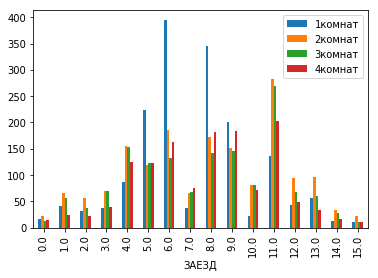

In [314]:
plt.figure(figsize=[20,15])
room[['1комнат', '2комнат', '3комнат', '4комнат']].plot(kind='bar')
plt.show()